# Setup and Preprocessing

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# tuning
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

# XGBoost Comparison

## nssi_bin

In [3]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Logistic regression model

In [4]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [5]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [6]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030
The mean precision with cross-validation is: 0.822 +/- 0.025
The mean recall with cross-validation is: 0.690 +/- 0.035
The mean AUROC with cross-validation is: 0.750 +/- 0.033


### XGBoost model

In [7]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=-1, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [8]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [9]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.723
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.697
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.705
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.727
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.752


In [10]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.688 +/- 0.028
The mean precision with cross-validation is: 0.799 +/- 0.023
The mean recall with cross-validation is: 0.719 +/- 0.034
The mean AUROC with cross-validation is: 0.731 +/- 0.032


((0.9639202737751931, 0.03607965153306236, 7.469174456709027e-08), <Figure size 640x480 with 1 Axes>)


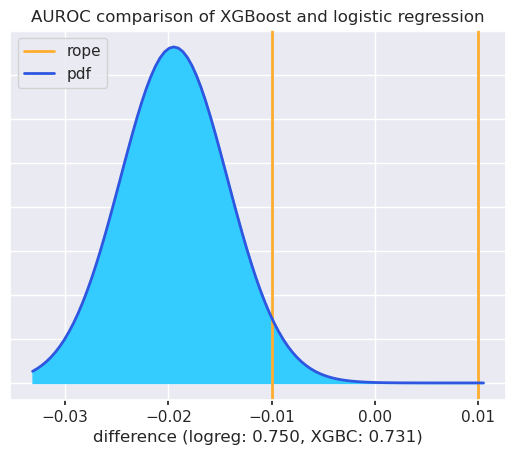

In [11]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## si_bin

In [12]:
# define target
target = data['si_bin']

### Logistic regression model

In [13]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [14]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [15]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.707 +/- 0.026
The mean precision with cross-validation is: 0.913 +/- 0.020
The mean recall with cross-validation is: 0.707 +/- 0.030
The mean AUROC with cross-validation is: 0.759 +/- 0.040


### XGBoost model

In [16]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=-1, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [17]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.712
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.762
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.801
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.745
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.776


In [19]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.742 +/- 0.027
The mean precision with cross-validation is: 0.899 +/- 0.018
The mean recall with cross-validation is: 0.769 +/- 0.033
The mean AUROC with cross-validation is: 0.761 +/- 0.040


((0.07349688135800482, 0.752078143586965, 0.17442497505503018), <Figure size 640x480 with 1 Axes>)


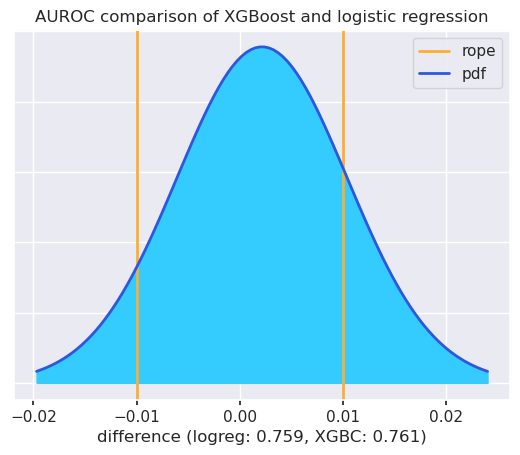

In [20]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## attempt_bin

In [21]:
# define target
target = data['attempt_bin']

### Logistic regression model

In [22]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [23]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [24]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.697 +/- 0.024
The mean precision with cross-validation is: 0.520 +/- 0.029
The mean recall with cross-validation is: 0.705 +/- 0.044
The mean AUROC with cross-validation is: 0.762 +/- 0.028


### XGBoost model

In [25]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=-1, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [26]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [27]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.727
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.776
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.795
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.740
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.737


In [28]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.693 +/- 0.027
The mean precision with cross-validation is: 0.517 +/- 0.035
The mean recall with cross-validation is: 0.633 +/- 0.051
The mean AUROC with cross-validation is: 0.748 +/- 0.028


((0.8092868255669244, 0.19071258127657809, 5.931564974748227e-07), <Figure size 640x480 with 1 Axes>)


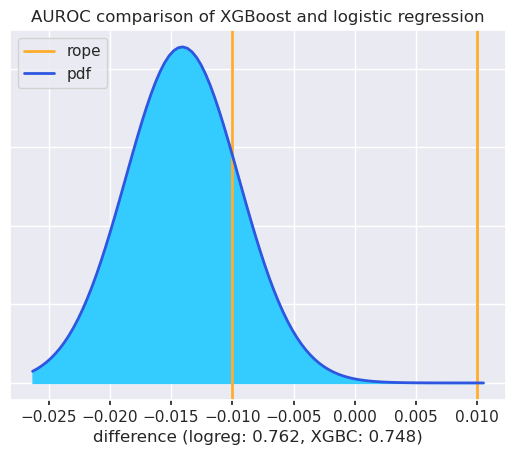

In [29]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## nssi_year

In [30]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

In [31]:
# define target
target = nssi_year_data['nssi_year']

# define features
features = nssi_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Poisson regression model

In [32]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [33]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [34]:
pipeline.set_params(poissonregressor__alpha=2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 89.948 +/- 24.689
The mean Poisson deviance with cross-validation is: 76.436 +/- 22.248


### XGBoost model

In [35]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [36]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [37]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 75.826
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 119.711
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 86.562
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 111.621
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 48.689


In [38]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=10)
pipeline.set_params(xgbregressor__n_estimators=100)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 92.117 +/- 25.133
The mean Poisson deviance with cross-validation is: 83.768 +/- 26.650


((0.0007474664658645673, 0.03171274344845598, 0.9675397900856795), <Figure size 640x480 with 1 Axes>)


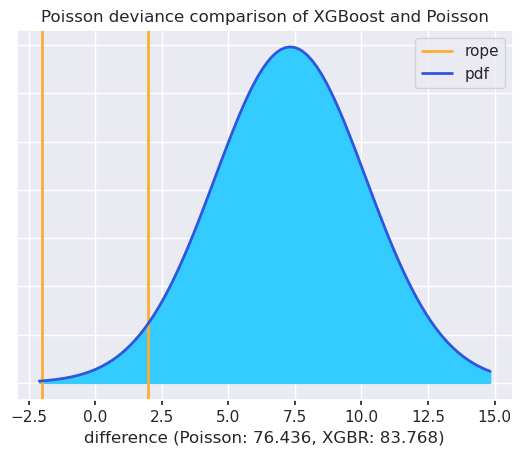

In [39]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## si_year

In [40]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# confirm new size of data set
si_year_data.shape

(2415, 18)

In [41]:
# define target
target = si_year_data['si_year']

# define features
features = si_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

### Poisson regression model

In [42]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [43]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [44]:
pipeline.set_params(poissonregressor__alpha=10)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 145.918 +/- 18.969
The mean Poisson deviance with cross-validation is: 135.715 +/- 21.016


### XGBoost model

In [45]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [46]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [47]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 132.921
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 178.906
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 158.392
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 0.1, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 167.473
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 0.5, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 136.123


In [48]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=2)
pipeline.set_params(xgbregressor__n_estimators=100)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 149.627 +/- 20.231
The mean Poisson deviance with cross-validation is: 153.371 +/- 28.739


((3.6349164890714736e-06, 0.00013399073027975383, 0.9998623743532312), <Figure size 640x480 with 1 Axes>)


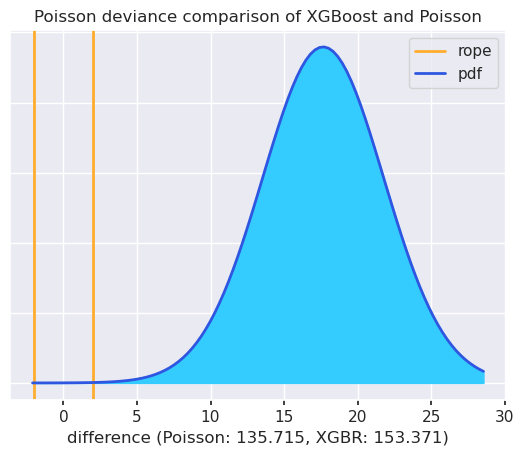

In [49]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## attempt_year

In [50]:
# drop records missing attempt_year for attempt_year models
attempt_year_data = data.dropna(subset='attempt_year')

# confirm new size of data set
attempt_year_data.shape

(2442, 18)

In [51]:
# define target
target = attempt_year_data['attempt_year']

# define features
features = attempt_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

### Poisson regression model

In [52]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [53]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [54]:
pipeline.set_params(poissonregressor__alpha=0.2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.008 +/- 0.730
The mean Poisson deviance with cross-validation is: 1.873 +/- 0.451


### XGBoost model

In [55]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=-1, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [56]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=-1)

cv_results = cross_validate(randomized_search, features, target, n_jobs=-1, return_estimator=True)

In [57]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 0.1, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.601
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 5, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 2.639
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.897
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 5, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.927
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.906


In [58]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=5)
pipeline.set_params(xgbregressor__n_estimators=50)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.065 +/- 0.742
The mean Poisson deviance with cross-validation is: 2.022 +/- 0.539


((3.5193500677220815e-63, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


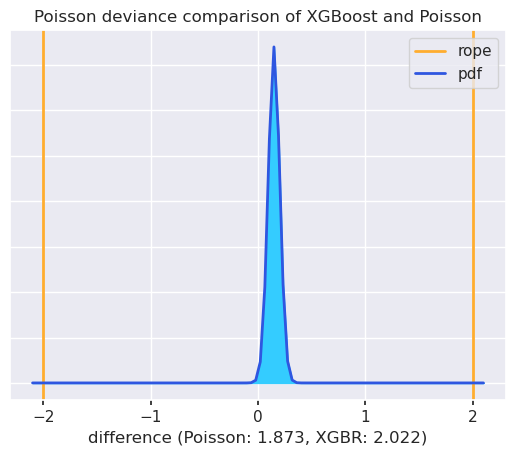

In [59]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## Summary

XGBoost did not outperform the scikit-learn models we tested.  
Performance of the XGBoost models was either comparable or worse compared to the best performing scikit-learn models.

# Sexual Orientation in Sexual Minority Group

In [60]:
# drop features to reduce multicollinearity
data.drop(labels=['hopelessness', 'peer_vict', 'behav_act'], axis=1, inplace=True)

In [61]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25, score='roc_auc'):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n), dtype='float64')
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring=score, 
                                              n_repeats=10, random_state=0, n_jobs=-1)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [62]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

In [63]:
# create subset of data for orientation minority group
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

## nssi_bin

In [83]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [84]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [85]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [86]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.668 +/- 0.007
The mean precision with cross-validation is: 0.835 +/- 0.007
The mean recall with cross-validation is: 0.675 +/- 0.016
The mean AUROC with cross-validation is: 0.729 +/- 0.014


                    mean       std
depression      0.044208  0.009758
discrimination  0.020626  0.007579
gender          0.019545  0.004846
child_adverse   0.017477  0.005901
sex             0.015761  0.007034
orientation     0.011085  0.004465
anxiety         0.008226  0.004058
hope            0.000906  0.003384
loneliness     -0.000419  0.001120


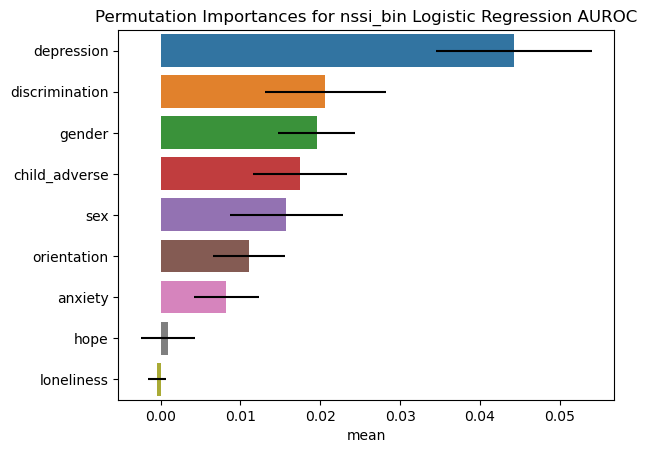

In [87]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

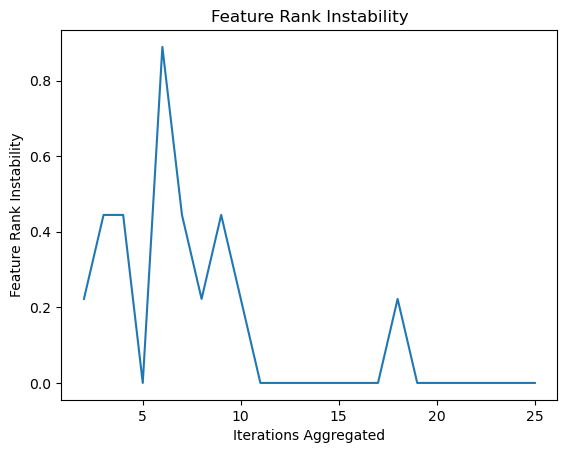

In [88]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_bin

In [89]:
# define target
target = data_minor['si_bin']

In [90]:
# get results from tuned model
pipeline.set_params(logisticregression__C=0.01)
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.669 +/- 0.013
The mean precision with cross-validation is: 0.920 +/- 0.017
The mean recall with cross-validation is: 0.672 +/- 0.018
The mean AUROC with cross-validation is: 0.706 +/- 0.050


                    mean       std
depression      0.074604  0.016380
child_adverse   0.033750  0.009465
gender          0.003664  0.002557
loneliness      0.001928  0.003790
anxiety         0.001681  0.004718
orientation     0.001196  0.003073
sex             0.001122  0.001970
hope           -0.000832  0.002124
discrimination -0.001245  0.002944


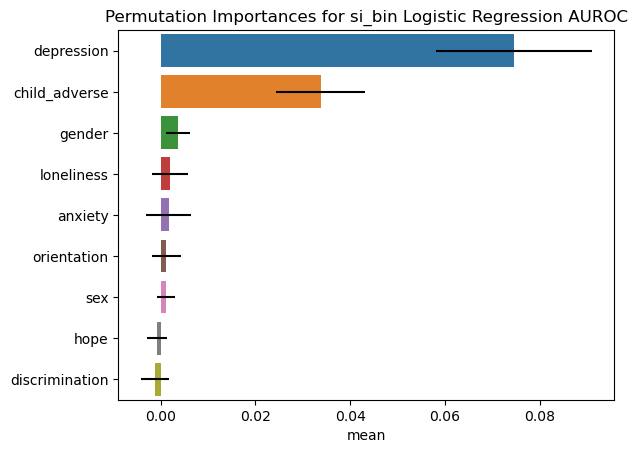

In [91]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

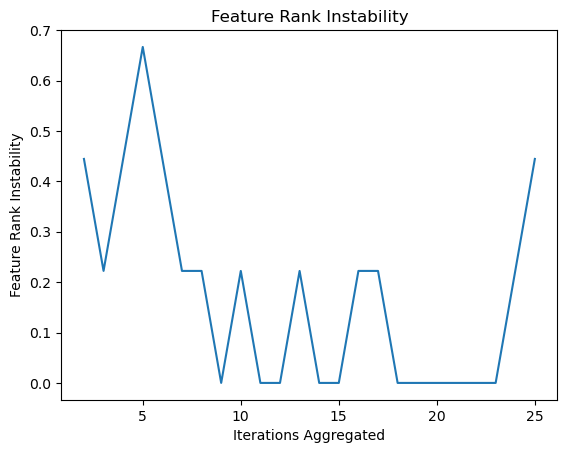

In [92]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## attempt_bin

In [93]:
# define target
target = data_minor['attempt_bin']

In [94]:
# get results from tuned model
pipeline.set_params(logisticregression__C=0.01)
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.670 +/- 0.021
The mean precision with cross-validation is: 0.531 +/- 0.025
The mean recall with cross-validation is: 0.678 +/- 0.025
The mean AUROC with cross-validation is: 0.738 +/- 0.026


                    mean       std
depression      0.048583  0.008778
discrimination  0.046945  0.007960
child_adverse   0.031243  0.007085
anxiety         0.001228  0.002535
orientation     0.000840  0.001740
hope            0.000630  0.001108
sex             0.000356  0.000518
gender          0.000181  0.003280
loneliness     -0.000530  0.001676


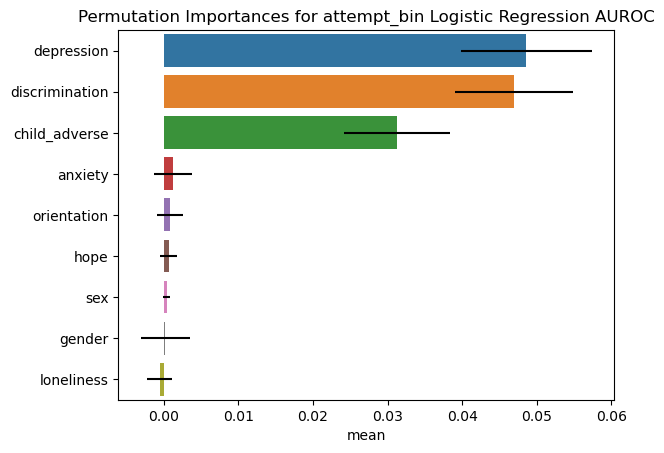

In [95]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

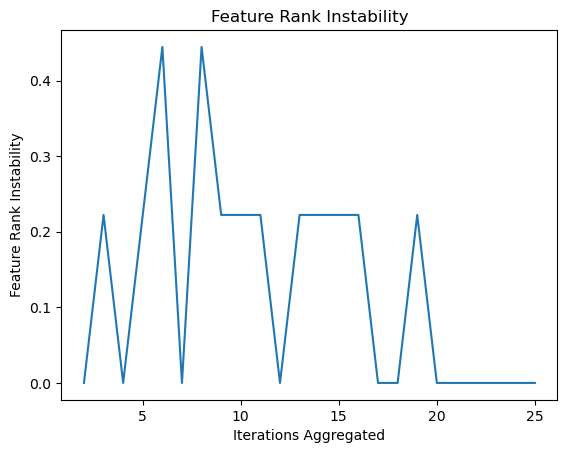

In [96]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## nssi_year

In [97]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subset of data for orientation minority group
data_minor = nssi_year_data[nssi_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [98]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [99]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [100]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [101]:
pipeline.set_params(poissonregressor__alpha=2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 98.498 +/- 25.542
The mean Poisson deviance with cross-validation is: 88.225 +/- 24.745


                     mean       std
depression      16.923759  5.258734
anxiety          3.066933  1.698189
discrimination   3.057571  2.447431
gender           2.811191  1.831026
sex              0.993391  0.397868
orientation      0.683062  1.085049
child_adverse   -0.036663  0.652499
loneliness      -0.115510  0.939637
hope            -0.130908  1.211508


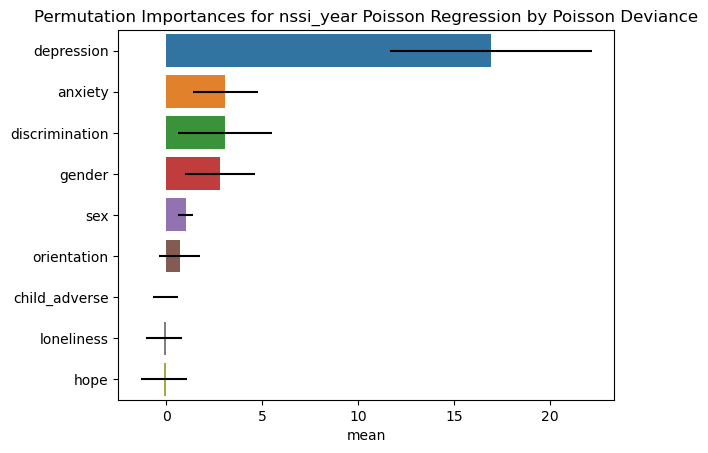

In [102]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

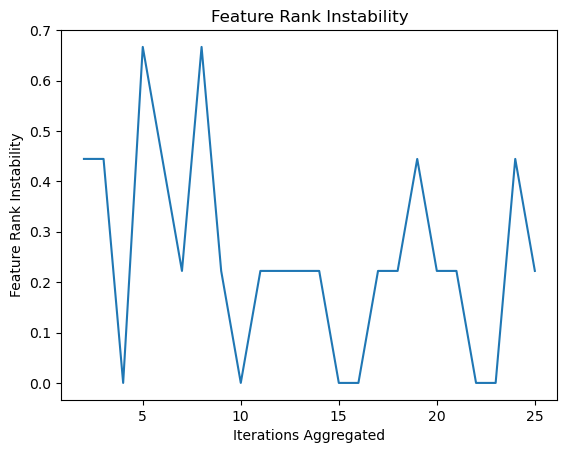

In [103]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_year

In [104]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subset of data for orientation minority group
data_minor = si_year_data[si_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [105]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [106]:
# get results from tuned model
pipeline.set_params(poissonregressor__alpha=10)
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 153.875 +/- 18.367
The mean Poisson deviance with cross-validation is: 148.461 +/- 20.228


                     mean       std
depression      22.800255  5.975258
anxiety          7.733928  2.757060
loneliness       1.718291  1.308695
child_adverse    1.568708  1.561617
discrimination   0.950841  1.980846
orientation      0.334006  0.943648
hope             0.035013  1.351315
gender          -0.175616  0.612017
sex             -0.268801  0.198151


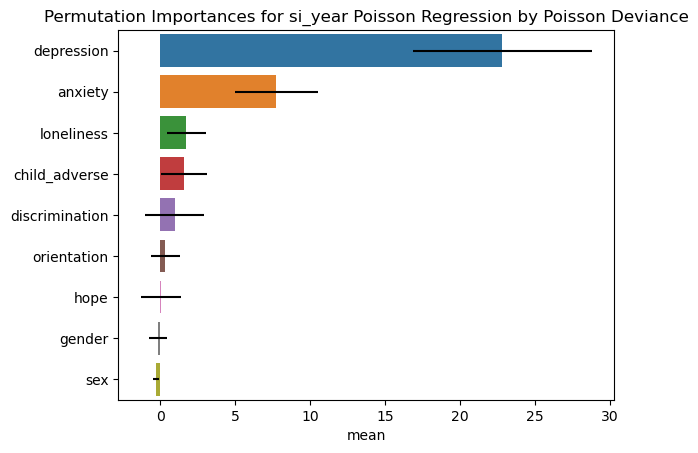

In [107]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

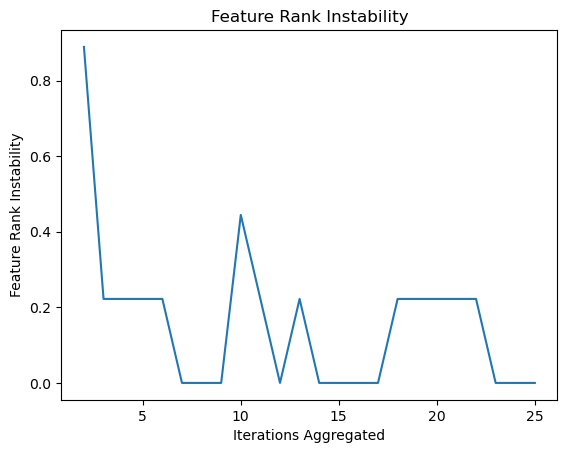

In [108]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## Summary

The feature importance of orientation was only reliably greater than 0 for nssi_bin,  
and even in that case, its feature importance ranking was only 6th out of 9 features.